# Viga simplemente apoyada

In [1]:
import numpy as np, pandas as pd

from matplotlib import pyplot as plt

In [2]:
m = 1

cm = 0.01*m
kg = 1.0
kN = 1000.0*kg/m

### 1. Introduccion

En este ejemplo se requiere predecir la **deflexión máxima** de una viga **simplemente apoyada con carga puntual centrada**

$$\sigma_{máx} = \frac{P*L**3}{48*E*I}$$
donde:
- P: Carga puntual en el centro (kN)
- L:m Lognitud de la viga
- E: Módulo de elasticidad
- I: Momento de inercia

Para solucionar usaremos 2 puntos de vista.
- Un **modelo de Machin Learning** (random forest Regresion)
- Formulacion clásica o Modelo Matemático de mecánica de materailes.

In [3]:
def gen_value_viga_simple(num_muestras = 10_000, random_sate=50):
    np.random.seed(random_sate)

    # Módulos de elasticidad para diferentes resistencias a la compresión del hormigón (fc) en MPa
    modulo_elasticidad = {
        175: 19_663_000,
        210: 21_541_000,
        280: 24_870_000,
        350: 27_805_000,
        420: 30_463_000,
    }
    claves_fc = list(modulo_elasticidad.keys())
    valores_E = list(modulo_elasticidad.values())

    # Longitudes entre 2 y 10 m, con incrementos de 0.05 m y ancho y altura entre 0.25 y 0.60 m y 0.30 y 1.00 m respectivamente
    longitud = np.round( np.random.uniform(2, 10, num_muestras)/0.05 ) * 0.05 # [m]
    ancho_b = np.round( np.random.uniform(0.25, 0.60, num_muestras)/0.05 ) * 0.05 # [m]
    altura_h = np.round( np.random.uniform(0.30, 1.00, num_muestras)/0.05 ) * 0.05 # [m]

    # Cargas aleatorias entre 10 y 100 kN
    cargasP = np.round(np.random.uniform(10, 100, num_muestras), 2) # [kN]

    idx_modulo_elasticidad = np.random.randint(0, len(valores_E), num_muestras)
    fc_values = [claves_fc[i] for i in idx_modulo_elasticidad]
    e_values = [valores_E[i] for i in idx_modulo_elasticidad]

    inercia_vals = (ancho_b * altura_h**3) / 12.0  # [m^4]

    idelta_vals = (cargasP*longitud**3) / (48 * np.array(e_values) * inercia_vals)

    data = pd.DataFrame({
        'L': longitud,  # [m]
        'b': ancho_b,  # [m]
        'h': altura_h,  # [m]
        'P': cargasP,  # [kN]
        'fc': fc_values,  # [MPa]
        'E': e_values,  # [MPa]
        "I": inercia_vals,  # [m^4]
        "deflexion_max_mm": idelta_vals*1000,  # [mm]
    })

    return data

In [4]:
data = gen_value_viga_simple(10_000)
data.head(7)

,L,b,h,P,fc,E,I,deflexion_max_mm
0,5.95,0.45,0.40,41.51,210,21541000,0.002400,3.523589
1,3.80,0.50,0.40,15.04,210,21541000,0.002667,0.299311
2,4.05,0.45,0.70,82.55,175,19663000,0.012863,0.451716
3,5.15,0.30,0.90,49.47,280,24870000,0.018225,0.310584
4,5.00,0.55,0.95,91.82,175,19663000,0.039296,0.309460
5,9.95,0.35,0.50,68.86,420,30463000,0.003646,12.724055
6,5.25,0.40,0.95,57.67,175,19663000,0.028579,0.309376


In [8]:
data.describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
L,10000.0,6.03,2.30,2.00,4.05,6.05,8.00,10.00
b,10000.0,0.42,0.10,0.25,0.35,0.40,0.50,0.60
h,10000.0,0.65,0.20,0.30,0.45,0.65,0.80,1.00
P,10000.0,54.87,26.00,10.00,32.25,55.06,77.38,100.00
fc,10000.0,288.21,89.80,175.00,210.00,280.00,350.00,420.00
E,10000.0,24921241.30,3956829.99,19663000.00,21541000.00,24870000.00,27805000.00,30463000.00
I,10000.0,0.01,0.01,0.00,0.00,0.01,0.02,0.05
deflexion_max_mm,10000.0,3.34,7.31,0.00,0.26,0.92,3.04,111.05


In [6]:
data_keys = data.drop(columns=['E', 'I'], axis=1)
data_keys = data_keys.keys()
data_keys

Index(['L', 'b', 'h', 'P', 'fc', 'deflexion_max_mm'], dtype='object')

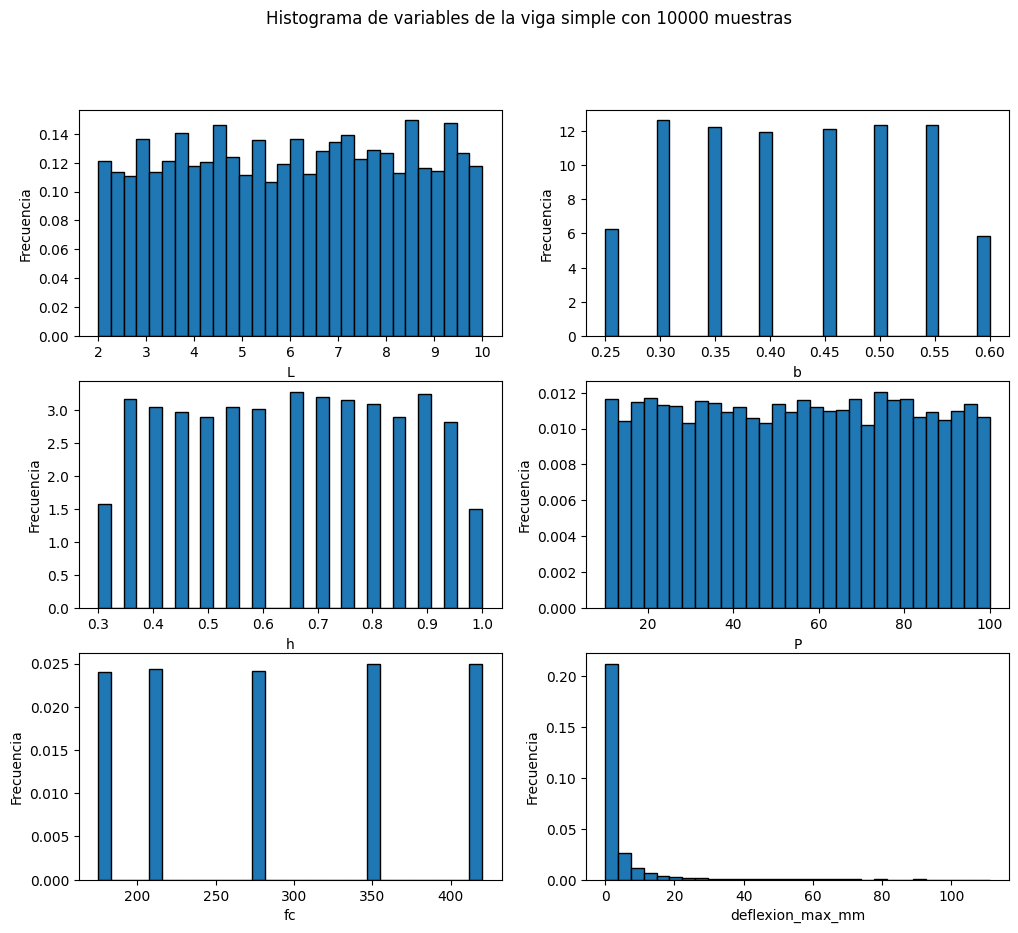

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(12, 10))
axs = ax.flatten() # lo convierte en una lista unidimensional
# print(axs)
fig.suptitle(f"Histograma de variables de la viga simple con {len(data)} muestras", pad=12)

for i, var in enumerate(data_keys):
    axs[i].hist( data[var], bins=30, edgecolor='black', density=True ) # , kde=True
    # axs[i].plot(data[var], 'r-', label='Media')
    axs[i].set_xlabel(var)
    axs[i].set_ylabel("Frecuencia")
plt.tight_layout
plt.show()

### 2. Entrenamento - Modelo de regresion

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#### Metricas para evaluar modelo de regresion

Raiz del error cuadratico medio.

$$RMSE=\sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_{i}-\widehat{y_i})^2}$$

Error Absoluto medio
$$MAE=\frac{1}{n}\sum_{i=1}^{n}|y_{i}-\widehat{y_i}^2|$$


Coeficiente de Determinación ($R^2$)

$$R^2 = 1- \frac{\sum_{i=1}^{n}(y_{i}-\widehat{y_i})^2}{\sum_{i=1}^{n}(y_{i}-\overline{y_i})^2}$$


| Métrica | Ideal | Lo que te puede indicar 
|----------|----------|----------
|RMSE|cercano a cero| Cuanto se devia el modelo|
|MAE|Cercano a cero| Promedio del error absoluto|
|👉$R^2$|Cercano a uno| Corelacion positiva para un modelo de regresion Linial

In [9]:
data_keys2 = data.drop(columns=['I', 'deflexion_max_mm'], axis=1)
data_keys2 = data_keys2.keys()
data_keys2

Index(['L', 'b', 'h', 'P', 'fc', 'E'], dtype='object')

In [10]:
X = data[data_keys2]
y = data['deflexion_max_mm']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 20% para la prueba y el 80 para el entrenamiento, con 42 de semilla para replicar

modelo = RandomForestRegressor(
    n_estimators=100, # 100 árboles
    max_depth=20, # numero máximo de niveles en cada árbol
    random_state=42 # para reproducibilidad
    )
modelo.fit(x_train, y_train) # entrenar el modelo
y_pred = modelo.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# mae = np.mean(np.abs(y_test - y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

display(pd.DataFrame({
    'Real': y_test,
    'Predicción': y_pred
}).head(10))
print(f"RMSE: {rmse:.3f} mm")
print(f"MAE: {mae:.3f} mm")
print(f"R^2: {r2:.4f}")

,Real,Predicción
6252,4.310603,3.907676
4684,0.015795,0.019444
1731,0.023888,0.032409
4742,0.392146,0.444441
4521,0.391406,0.427847
6340,1.074570,1.024573
576,1.956665,2.168209
5202,1.372749,1.847905
6363,6.941776,8.442404
439,0.082960,0.087862


RMSE: 1.705 mm
MAE: 0.466 mm
R^2: 0.9577


In [11]:
# from sklearn.tree import plot_tree

# plt.figure(figsize=(20, 12))
# plot_tree(modelo.estimators_[0],
#           feature_names=data_keys2,
#           filled=True,
#           rounded=True,
#           fontsize=10)
# plt.title("Árbol de Regresión")
# plt.show()

### 4. Visualizacion del modelo

In [12]:
import plotly.graph_objs as go
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=y_test, 
    y=y_pred, 
    mode='markers', 
    name='Predicciones',
    marker=dict(color='blue', size=5)
))
fig.add_trace(go.Scatter(
    x=y_test, 
    y=y_test, 
    mode='lines', 
    name='Línea de referencia',
    line=dict(color='red', width=2)
))
fig.update_layout(
    title='Predicciones vs Valores Reales',
    xaxis_title='Valores Reales (mm)',
    yaxis_title='Predicciones (mm)',
    width=800,
    height=600
)
fig.show()

In [13]:
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.scatter(y_test, y_pred, alpha=0.5)
# ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
# ax.set_xlabel('Valores Reales (mm)')
# ax.set_ylabel('Predicciones (mm)')
# ax.set_title('Valores Reales vs Predicciones')
# plt.grid()
# plt.tight_layout()
# plt.show()

### 5. Comparativa

In [14]:
def predece_y_compara(datos_viga, modelo):
    data_in = pd.DataFrame([datos_viga])[data_keys2]

    pred_ml = modelo.predict(data_in)[0]

    # Calculo teorico
    longitud = datos_viga['L']
    carga = datos_viga['P']  # Convertir a N
    ancho_b = datos_viga['b']
    altura_h = datos_viga['h']
    E = datos_viga['E']
    I = (ancho_b * altura_h**3) / 12.0  # [m^4]
    deflexion_teorico = (carga * longitud**3) / (48 * E * I) * 1000  # [mm]

    error = abs(pred_ml - deflexion_teorico)
    error_relativo = error / deflexion_teorico * 100

    print(f"Cálculo Teorico ......: {deflexion_teorico:.2f} mm")
    print(f"C+alculo Prediccion ML: {pred_ml:.2f} mm")
    print(f"Error: {error:.4f} ({error_relativo:.2f}%)")

    return 0


In [15]:
datos_viga = {
    "L": 2.0 * (m),
    "P": 50.0 * (kN),
    "b": 0.30 * (m),
    "h": 0.50 * (m),
    "fc": 280 * (kg/cm**2),
    "E": 24_870_000 * (m**2),
}

response = predece_y_compara(datos_viga, modelo)
response

Cálculo Teorico ......: 107.22 mm
C+alculo Prediccion ML: 0.20 mm
Error: 107.0258 (99.81%)


0